In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import scipy.stats as stats
from scipy.stats import shapiro, mannwhitneyu

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    LabelEncoder,
    StandardScaler,
    FunctionTransformer,
)
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.metrics import precision_score, f1_score, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

%matplotlib inline
pd.set_option("display.max_rows", None, "display.max_columns", None)
import warnings

warnings.filterwarnings("ignore")
print("Setup complete")

Setup complete


<IPython.core.display.Javascript object>

# LOAN Prediction

The aim of this work is to create an ML project that will predict whether a loan request will be accepted or rejected, and to determine the loan grade and the loan interest rate.

Objectives for this Part<br>
Practice downloading datasets from external sources.<br>
Practice performing EDA.<br>
Practice applying statistical inference procedures.<br>
Practice using various types of machine learning models.<br>
Practice building ensembles of machine learning models.<br>
Practice using hyperparameter tuning.<br>
Practice using AutoML tools.<br>
Practice deploying machine learning models.<br>
Practice visualizing data with Matplotlib & Seaborn.<br>
Practice reading data, performing queries, and filtering data.

Requirements
Download the data from here.<br>
Perform exploratory data analysis. This should include creating statistical summaries and charts, testing for anomalies, checking for correlations and other relations between variables, and other EDA elements.<br>
Perform statistical inference. This should include defining the target population, forming multiple statistical hypotheses and constructing confidence intervals, setting the significance levels, conducting z or t-tests for these hypotheses.<br>
Apply various machine learning models to predict the target variables based on your proposed plan. You should use hyperparameter tuning, model ensembling, the analysis of model selection, and other methods. The decision where to use and not to use these techniques is up to you, however, they should be aligned with your team's objectives.<br>
Deploy these machine learning models to Google Cloud Platform. You are free to choose any deployment option you wish as long as it can be called an HTTP request.<br>
Provide clear explanations in your notebook. Your explanations should inform the reader what you are trying to achieve, what results you got, and what these results mean.<br>
Provide suggestions about how your analysis and models can be improved.

## Data Description

The goal of this project is to predict whether a loan will be paid off BEFORE making the decision to lend the loan.So, I remove the features that were unavailable before lending a loan.

I will only keep the rows with loan_status being "fully paid" or "charged off". Assuming that they both meet the credit policy
* Considering "good" loan: in our data I will group Fully Paid, Does not meet the credit policy. Status:Fully Paid as 1
* Considering "default" loan: Charged Off, Does not meet the credit policy. Status:Charged Off as 0
* The remaining loan_status I consider ongoing therefore for my modeling part it will be not useful.

Here is the information on this particular data set:
** Note: A FICO Score is a three-digit number based on the information in your credit reports. It helps lenders determine how likely you are to repay a loan. This, in turn, affects how much you can borrow, how many months you have to repay, and how much it will cost (the interest rate).
 FICO score is a number typically on a 300-850 range used by lenders to determine your ability to pay back borrowed debt. A score of 690-719 is generally considered good credit.    

In [3]:
columns_description = pd.read_excel("LCDataDictionary.xlsx")
columns_description.style.set_properties(subset=["Description"], **{"width": "1000px"})

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts for which the borrower is currently overdue.
1,acc_open_past_24mths,Number of trades opened in past 24 months
2,addr_state,The state provided by the borrower in the loan application
3,all_util,Balance to credit limit on all trades
4,annual_inc,The annual income provided by the borrower during registration.
5,annual_inc_joint,The combined self-reported annual income provided by the co-borrowers during registration.
6,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers.
7,avg_cur_bal,Average current balance of all accounts.
8,bc_open_to_buy,Total open to buy on revolving bankcards.
9,bc_util,Ratio of total current balance to high credit/credit limit for all bankcard accounts.


<IPython.core.display.Javascript object>

In [3]:
df = pd.read_csv("accepted_2007_to_2018Q4.csv", low_memory=False)
df_copy = df.copy()
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN,N

<IPython.core.display.Javascript object>

In [5]:
df.shape

(2260701, 151)

<IPython.core.display.Javascript object>

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


<IPython.core.display.Javascript object>

In [6]:
df.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
count,0.0,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260664e+06,2.258957e+06,2.260639e+06,2.260668e+06,2.260668e+06,2.260638e+06,1.102166e+06,359156.000000,2.260639e+06,2.260639e+06,2.260668e+06,2.258866e+06,2.260639e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260523e+06,580775.000000,2260668.0,1.207100e+05,120706.000000,2.260639e+06,2.190392e+06,2.190392e+06,1.394538e+06,1.394539e+06,1.394539e+06,1.394539e+06,1.350744e+06,1.394539e+06,1.191818e+06,1.394539e+06,1.394539e+06,1.394539e+06,1.394320e+06,2.190392e+06,1.394539e+06,1.394538e+06,1.394538e+06,2.210638e+06,2.190322e+06,2.185733e+06,2.184597e+06,2.260523e+06,2.260639e+06,2.121597e+06,2.190391e+06,2.190391e+06,2.190392e+06,2.210638e+06,2.187256e+06,519701.000000,1.965233e+06,740359.000000,2.190392e+06,2.190392e+06,2.190392e+06,2.202078e+06,2.190392e+06,2.190392e+06,2.190392e+06,2.190391e+06,2.190392e+06,2.202078e+06,2.107011e+06,2.190392e+06,2.190392e+06,2.190392e+06,2.190237e+06,2.185289e+06,2.259303e+06,2.260563e+06,2.190392e+06,2.210638e+06,2.210638e+06,2.190392e+06,1.080200e+05,108021.000000,108021.000000,108021.000000,108021.000000,108021.000000,106184.000000,108021.000000,108021.000000,108021.000000,108021.000000,35942.000000,10917.0,10917.000000,10917.0,10917.000000,8651.000000,10917.000000,10917.000000,34246.000000,34246.000000,34246.000000
mean,NaN,1.504693e+04,1.504166e+04,1.502344e+04,1.309283e+01,4.458068e+02,7.799243e+04,1.882420e+01,3.068792e-01,6.985882e+02,7.025884e+02,5.768354e-01,3.454092e+01,72.312842,1.161240e+01,1.975278e-01,1.665846e+04,5.033770e+01,2.416255e+01,4.206891e+03,4.205965e+03,1.208256e+04,1.206439e+04,9.505772e+03,2.431388e+03,1.518453e+00,1.438791e+02,2.398257e+01,3.429346e+03,6.876610e+02,6.755397e+02,1.814580e-02,44.164220,1.0,1.236246e+05,19.251817,4.147942e-03,2.327317e+02,1.424922e+05,9.344199e-01,2.779407e+00,6.764314e-01,1.562752e+00,2.122236e+01,3.550665e+04,6.914098e+01,1.290133e+00,2.749923e+00,5.806393e+03,5.703230e+01,3.457394e+04,1.012867e+00,1.47

<IPython.core.display.Javascript object>

* Merging fully paid and Does not meet the credit policy. Status:Fully Paid also Charged Off and Does not meet the credit policy. Status:Charged Off

In [4]:
df["loan_status"] = df["loan_status"].str.replace(
    "Does not meet the credit policy. Status:", ""
)
df = df[(df["loan_status"] == "Fully Paid") | (df["loan_status"] == "Charged Off")]
df["loan_status"] = np.where(df["loan_status"] == "Fully Paid", 1, 0)

<IPython.core.display.Javascript object>

Simplyfy the loan issue date and keep only year:

In [5]:
df["issue_d"] = pd.to_datetime(df["issue_d"], format="%b-%Y").dt.year

<IPython.core.display.Javascript object>

Checking rows with all missing values:

In [6]:
null_rows = df[df.iloc[:, 1:].isnull().all(axis=1)].index
df.drop(null_rows, inplace=True)

<IPython.core.display.Javascript object>

In [7]:
def missing_values_summary(df):
    missing_values = df.isnull().sum()
    missing_values_percent = 100 * df.isnull().sum() / len(df)
    missing_values_type = df.dtypes
    missing_values_table = pd.concat(
        [missing_values, missing_values_percent, missing_values_type], axis=1
    )
    missing_values_table = missing_values_table.rename(
        columns={0: "Missing Values", 1: "% of Total Values", 2: "type"}
    )
    missing_values_table = (
        missing_values_table[missing_values_table.iloc[:, 1] != 0]
        .sort_values("% of Total Values", ascending=False)
        .round(4)
    )
    print(
        "There are "
        + str(missing_values_table.shape[0])
        + " columns that have missing values."
    )
    return missing_values_table


missing_values_summary(df)

There are 113 columns that have missing values.


,Missing Values,% of Total Values,type
member_id,1348059,100.0000,float64
next_pymnt_d,1345310,99.7961,object
orig_projected_additional_accrued_interest,1344300,99.7212,float64
hardship_status,1342305,99.5732,object
hardship_length,1342305,99.5732,float64
hardship_type,1342305,99.5732,object
hardship_reason,1342305,99.5732,object
deferral_term,1342305,99.5732,float64
hardship_amount,1342305,99.5732,float64
hardship_start_date,1342305,99.5732,object


<IPython.core.display.Javascript object>

I will drop the features with the following criteria:

More than 30% of the data is missing
The feature would not have been available at the time of the loan application ("issue_d").

In [8]:
missing_vals = 100 * df.isnull().sum() / len(df)
drop_list = sorted(missing_vals[missing_vals > 30].index)
df.drop(labels=drop_list, axis=1, inplace=True)

<IPython.core.display.Javascript object>

Checking for duplicated values based on unique id:

In [12]:
df.duplicated(subset=["id"]).sum()

0

<IPython.core.display.Javascript object>

Drop columns with only 1 value:

In [9]:
def single_value_features(df):
    single_feature = []
    for column in list(df.columns):
        if df[column].unique().size <= 1:
            single_feature.append(column)
    return single_feature


single_value_feature = single_value_features(df)
print(single_value_feature)
df.drop(single_value_feature, axis=1, inplace=True)

['pymnt_plan', 'out_prncp', 'out_prncp_inv', 'policy_code', 'hardship_flag']


<IPython.core.display.Javascript object>

* After checking the description of the features, I have decided to keep the ones that will help in the modelling of loan acceptance/rejection.
- features that contain the relevant customer credit detail (annual income, FICO score, and debt-to-income ratio).
- features that are available to investors (features in the loan application, loan grade and interest rate).

The data focuses on three different aspects:
1. Personal details (for example address, employment, homeownership).
2. Credit history (for example: whether the borrower has filed for bankruptcy, the balance of
all accounts, inquiries, revolving and currently past due accounts).
3. Loan characteristics (for example issue date, the FICO score, purpose, term).

Not all features will be available to us before a person gets loan. \ Some features will only be available after a person gets a loan. We have the following features we will be proceeding with:

In [10]:
features_keep = [
    "loan_amnt",
    "term",
    "emp_length",
    "home_ownership",
    "annual_inc",
    "loan_status",
    "purpose",
    "addr_state",
    "earliest_cr_line",
    "open_acc",
    "revol_bal",
    "revol_util",
    "total_acc",
    "application_type",
    "tot_cur_bal",
    "mort_acc",
    "num_actv_bc_tl",
    "pub_rec_bankruptcies",
    "acc_open_past_24mths",
    "mo_sin_rcnt_rev_tl_op",
    "mo_sin_old_rev_tl_op",
    "dti",
    "fico_range_high",
    "fico_range_low",
    "mths_since_recent_inq",
    "issue_d",
    "int_rate",
    "grade",
    "sub_grade",
]
drop_list = [col for col in df.columns if col not in features_keep]
df.drop(labels=drop_list, axis=1, inplace=True)
df.shape

(1348059, 29)

<IPython.core.display.Javascript object>

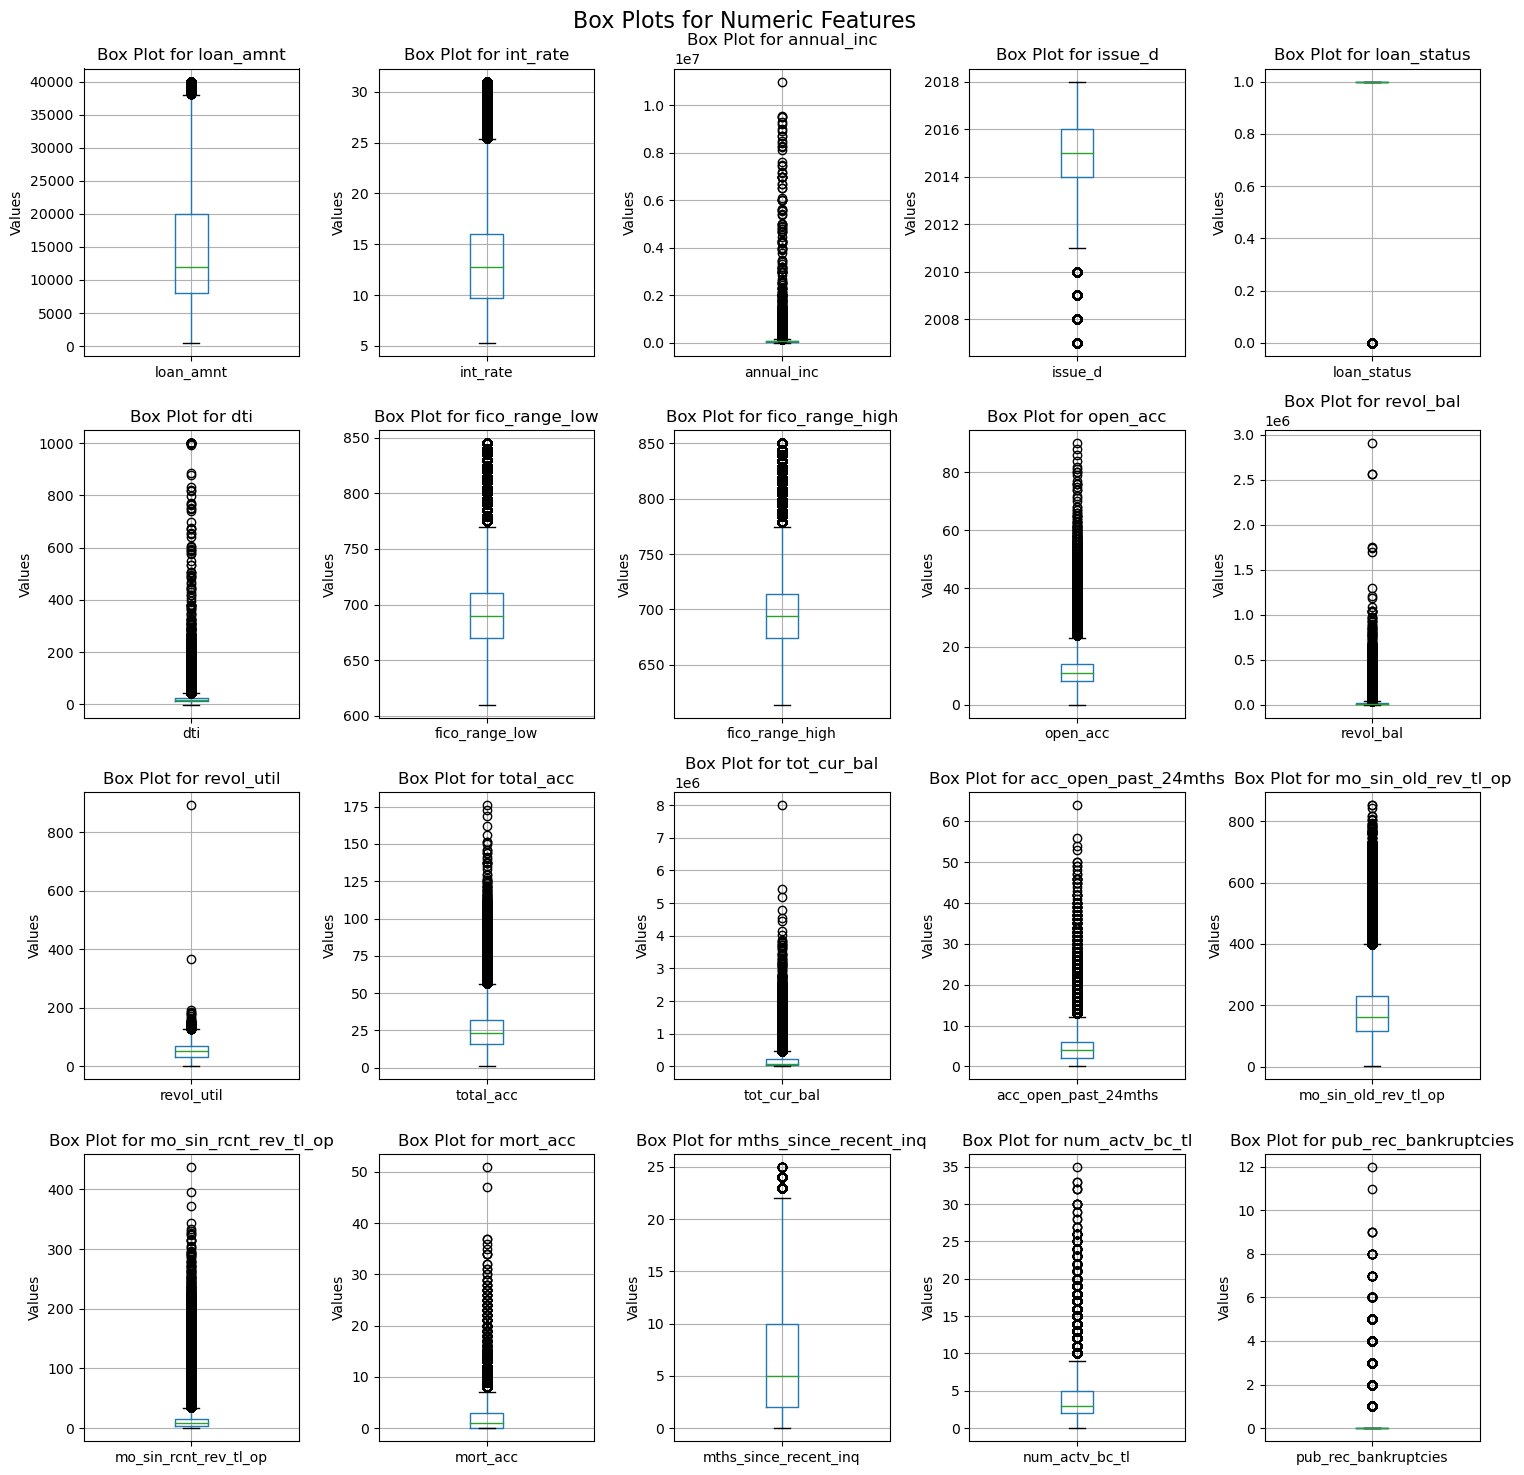

<IPython.core.display.Javascript object>

In [21]:
numeric_features = df.select_dtypes(exclude=["object"]).columns.tolist()
fig, axes = plt.subplots(4, 5, figsize=(15, 15))
axes = axes.flatten()
for i, feature in enumerate(numeric_features):
    df.boxplot(column=feature, ax=axes[i])
    axes[i].set_title(f"Box Plot for {feature}")
    axes[i].set_ylabel("Values")
for i in range(len(numeric_features), len(axes)):
    axes[i].axis("off")
fig.suptitle("Box Plots for Numeric Features", fontsize=16)
plt.tight_layout()
plt.show()

loan_status              1.000000
fico_range_low           0.130725
fico_range_high          0.130724
mort_acc                 0.075294
tot_cur_bal              0.071206
mths_since_recent_inq    0.056199
mo_sin_rcnt_rev_tl_op    0.053937
mo_sin_old_rev_tl_op     0.050502
annual_inc               0.041729
revol_bal                0.019635
total_acc                0.011397
pub_rec_bankruptcies    -0.025345
open_acc                -0.027880
num_actv_bc_tl          -0.041598
issue_d                 -0.049047
revol_util              -0.060017
loan_amnt               -0.065294
dti                     -0.084227
acc_open_past_24mths    -0.099869
int_rate                -0.258563
Name: loan_status, dtype: float64


<AxesSubplot: >

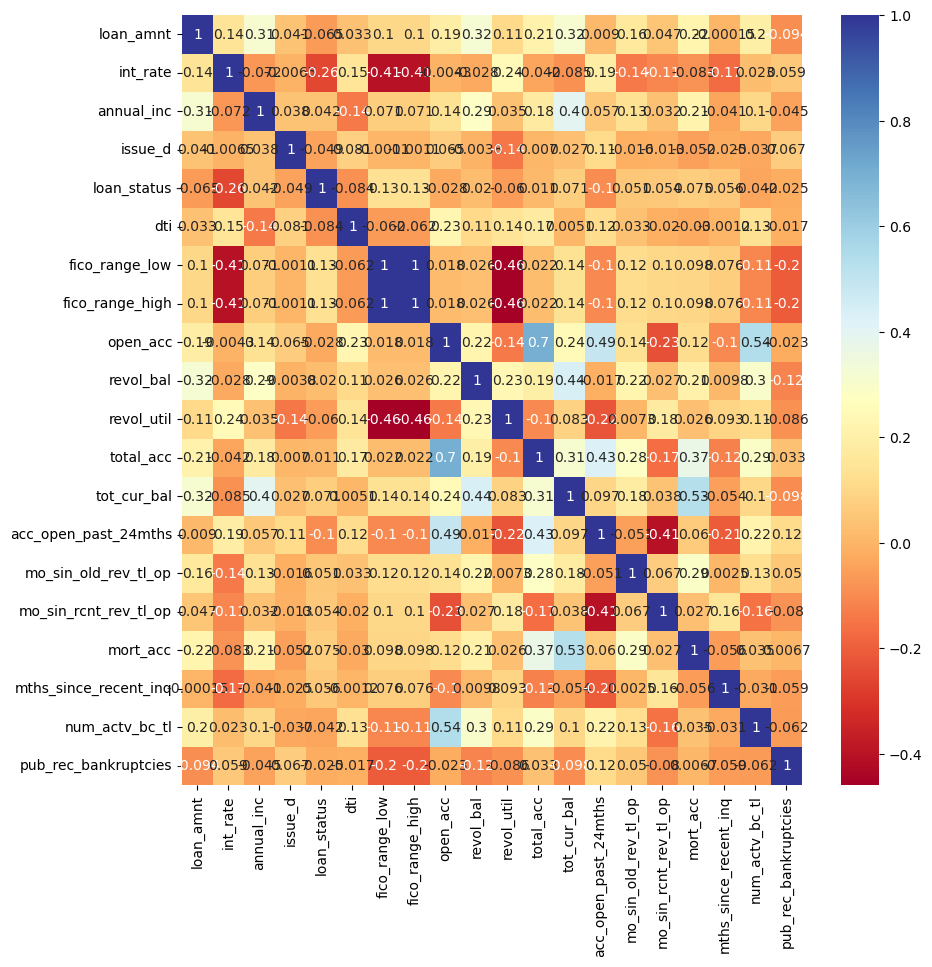

<IPython.core.display.Javascript object>

In [16]:
correlations = df.corr(numeric_only=True)["loan_status"].sort_values(ascending=False)
print(correlations)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(
    df.corr(numeric_only=True),
    annot=True,
    fmt=".2g",
    cmap="RdYlBu",
    cbar=True,
)

### What is the annual loan amount?

As we see rapid loan requests rises in 2015 and quantity in general falls.

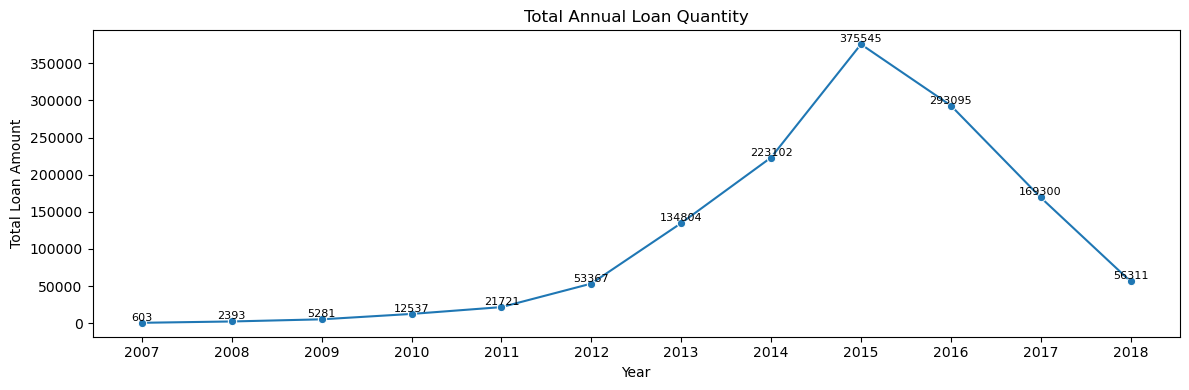

<IPython.core.display.Javascript object>

In [17]:
client_totals = df.issue_d.value_counts().reset_index()
plt.figure(figsize=(12, 4))
sns.lineplot(
    data=client_totals,
    x="issue_d",
    y="count",
    marker="o",
    linestyle="-",
    ci=None,
)
for x, y in zip(client_totals["issue_d"], client_totals["count"]):
    plt.text(x, y, str(y), ha="center", va="bottom", fontsize=8)
plt.xticks(client_totals["issue_d"])
plt.xlabel("Year")
plt.ylabel("Total Loan Amount")
plt.title("Total Annual Loan Quantity")
plt.tight_layout()
plt.show()

### What is the anual mean of loans requested LC?

As loan number decreases after 2015, in averrage the size of the loans remains about the same with a little increase in 2018.

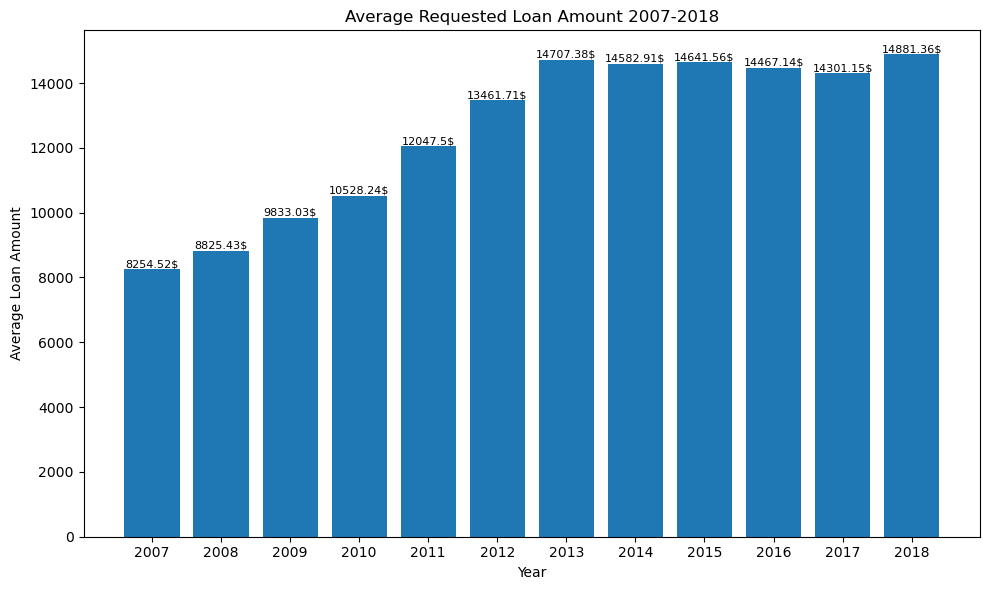

<IPython.core.display.Javascript object>

In [18]:

yearly_totals = round(df.groupby(df["issue_d"])["loan_amnt"].mean(), 2).reset_index()
yearly_totals = yearly_totals.sort_values(by="loan_amnt", ascending=False)
plt.figure(figsize=(10, 6))
bars = plt.bar(yearly_totals["issue_d"], yearly_totals["loan_amnt"])
for bar, total in zip(bars, yearly_totals["loan_amnt"]):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        total + 5,
        str(total) + "$",
        ha="center",
        va="bottom",
        fontsize=8,
    )
plt.xticks(yearly_totals["issue_d"])
plt.xlabel("Year")
plt.ylabel("Average Loan Amount")
plt.title("Average Requested Loan Amount 2007-2018")
plt.tight_layout()
plt.show()

Since my aim is to examine the charged off and fully payed aspect, it will be the main focus in the future.

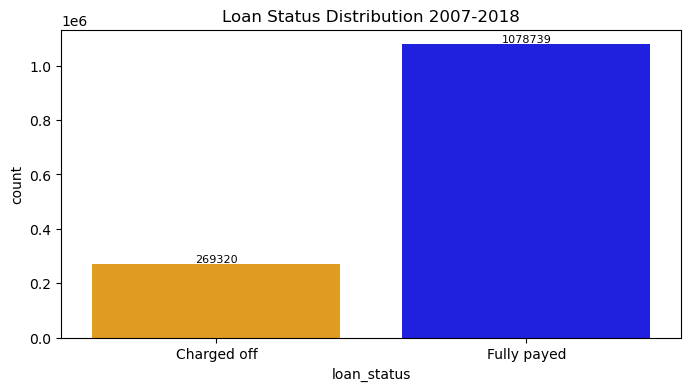

<IPython.core.display.Javascript object>

In [19]:
plt.figure(figsize=(8, 4))
custom_palette = {1: "blue", 0: "orange"}
bars = sns.countplot(x=df["loan_status"], data=df, palette=custom_palette)
for bar in bars.patches:
    height = bar.get_height()
    plt.annotate(
        f"{int(height)}",
        (bar.get_x() + bar.get_width() / 2, height + 10),
        ha="center",
        va="bottom",
        fontsize=8,
    )

plt.title("Loan Status Distribution 2007-2018")
plt.xticks([1, 0], ["Fully payed", "Charged off"])
plt.show()

While the total number of loans increased in 2015, we also see an increase in the outstanding loans column:

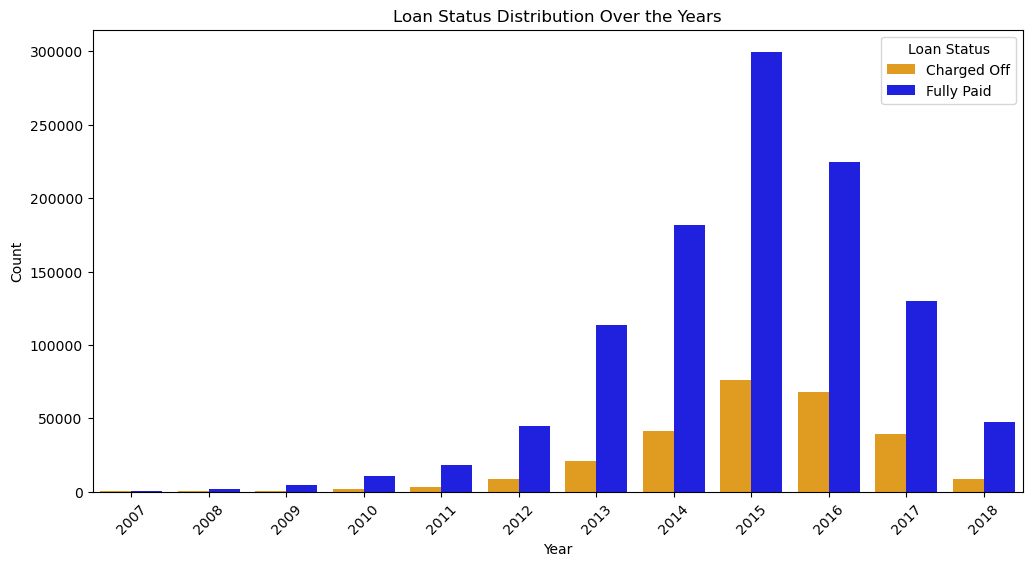

<IPython.core.display.Javascript object>

In [20]:
plt.figure(figsize=(12, 6))
custom_palette = {1: "blue", 0: "orange"}
sns.countplot(x=df["issue_d"], hue=df["loan_status"], palette=custom_palette)
plt.title("Loan Status Distribution Over the Years")
plt.xlabel("Year")
plt.ylabel("Count")
legend_labels = ["Charged Off", "Fully Paid"]
plt.legend(title="Loan Status", loc="upper right", labels=legend_labels)
x_labels = [
    "2007",
    "2008",
    "2009",
    "2010",
    "2011",
    "2012",
    "2013",
    "2014",
    "2015",
    "2016",
    "2017",
    "2018",
]
plt.xticks(range(len(x_labels)), labels=x_labels, rotation=45)
plt.show()

* **Loan amount** in relation to loan status:
We see that in averrage the mean of charged off loans is higher than fully payed loans.

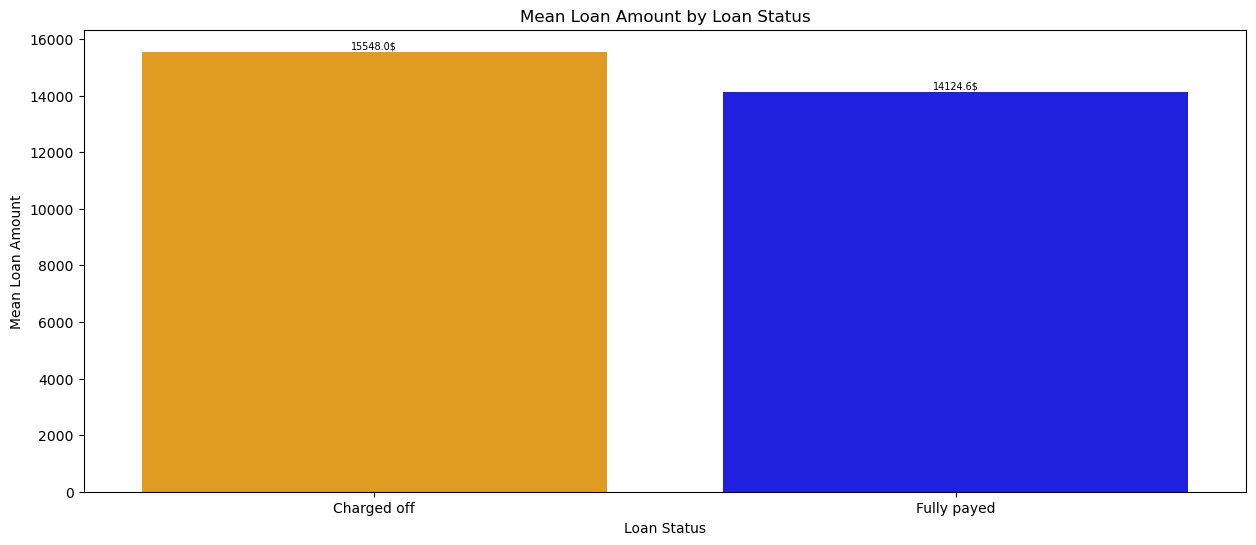

<IPython.core.display.Javascript object>

In [21]:
mean_loan_amounts = round(
    df.groupby("loan_status")["loan_amnt"].mean(), 2
).reset_index()

plt.figure(figsize=(15, 6))
custom_palette = {1: "blue", 0: "orange"}
ax = sns.barplot(
    x="loan_status", y="loan_amnt", data=mean_loan_amounts, palette=custom_palette
)
plt.title("Mean Loan Amount by Loan Status")
plt.xlabel("Loan Status")
plt.ylabel("Mean Loan Amount")
for i in ax.patches:
    ax.annotate(
        f"{i.get_height():.1f}$",
        (i.get_x() + i.get_width() / 2, i.get_height()),
        textcoords="offset points",
        xytext=(0, 2),
        size=7,
        ha="center",
    )
legend_labels = ["Charged Off", "Fully Paid"]
plt.xticks([0, 1], ["Charged off", "Fully payed"])
plt.show()

* **Term**
plot shows that 36 month term loand are better fully payed than long term loans.

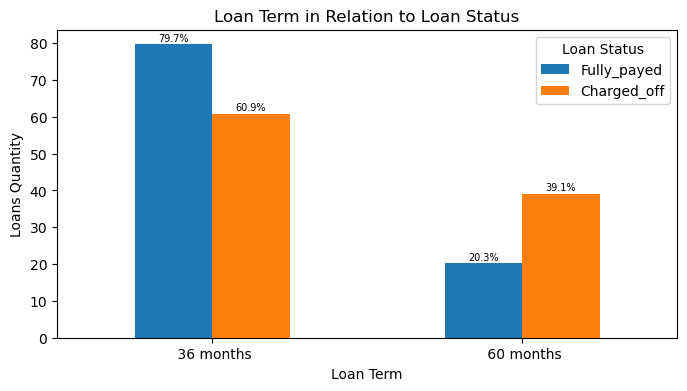

<IPython.core.display.Javascript object>

In [22]:
fully_payed_df = df[df["loan_status"] == 1]
charged_off_df = df[df["loan_status"] == 0]
fully_payed_term = fully_payed_df["term"].value_counts()
charged_off_term = charged_off_df["term"].value_counts()
term_counts_df = pd.DataFrame(
    {
        "Fully_payed": fully_payed_term,
        "Charged_off": charged_off_term,
    }
)
term_counts_df.sort_index(inplace=True)
term_counts_df["Fully_payed"] = round(
    term_counts_df["Fully_payed"] * 100 / term_counts_df["Fully_payed"].sum(), 2
)
term_counts_df["Charged_off"] = round(
    term_counts_df["Charged_off"] * 100 / term_counts_df["Charged_off"].sum(), 2
)
fig, ax = plt.subplots(figsize=(8, 4))
term_counts_df.plot(kind="bar", ax=ax)
for i in ax.patches:
    ax.annotate(
        f"{i.get_height():.1f}%",
        (i.get_x() + i.get_width() / 2, i.get_height()),
        textcoords="offset points",
        xytext=(0, 2),
        size=7,
        ha="center",
    )
ax.set_title("Loan Term in Relation to Loan Status")
ax.set_xlabel("Loan Term")
plt.xticks(rotation=0)
ax.set_ylabel("Loans Quantity")
plt.legend(title="Loan Status", loc="upper right")
plt.show()

* **Interest rate**: 
The fall in the interest rate shows that there is a direct link between the sudden increase in the number of loans. A link can also be drawn with the increase in charged off loans (economic crisis). In general we see that Charged off loans have higher interest rate than fully payed loans.


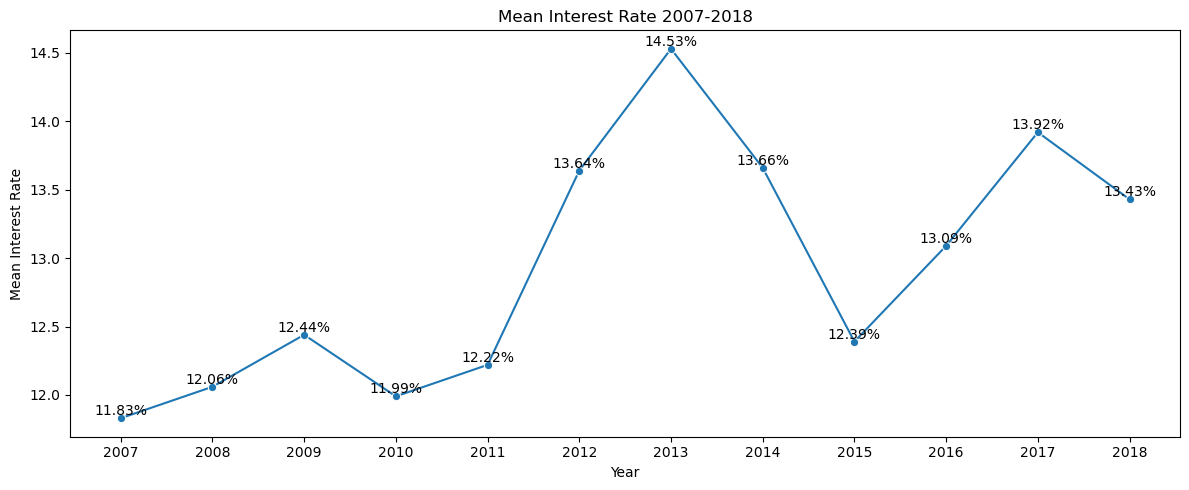

<IPython.core.display.Javascript object>

In [23]:
mean_int_rate = round(df.groupby(df["issue_d"])["int_rate"].mean(), 2).reset_index()
plt.figure(figsize=(12, 5))
sns.lineplot(
    data=mean_int_rate,
    x="issue_d",
    y="int_rate",
    marker="o",
    linestyle="-",
    ci=None,
)
for x, y in zip(mean_int_rate["issue_d"], mean_int_rate["int_rate"]):
    plt.text(x, y, str(y) + "%", ha="center", va="bottom", fontsize=10)
plt.xticks(mean_int_rate["issue_d"])
plt.xlabel("Year")
plt.ylabel("Mean Interest Rate")
plt.title("Mean Interest Rate 2007-2018")
plt.tight_layout()
plt.show()

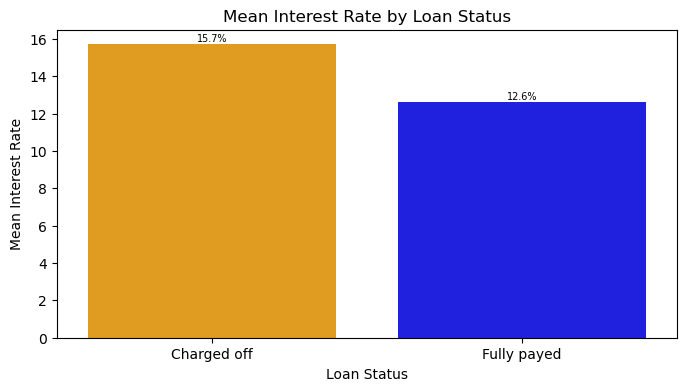

<IPython.core.display.Javascript object>

In [24]:
mean_interest_rate = round(
    df.groupby("loan_status")["int_rate"].mean(), 2
).reset_index()

plt.figure(figsize=(8, 4))
custom_palette = {1: "blue", 0: "orange"}
ax = sns.barplot(
    x="loan_status", y="int_rate", data=mean_interest_rate, palette=custom_palette
)
plt.title("Mean Interest Rate by Loan Status")
plt.xlabel("Loan Status")
plt.ylabel("Mean Interest Rate")
for i in ax.patches:
    ax.annotate(
        f"{i.get_height():.1f}%",
        (i.get_x() + i.get_width() / 2, i.get_height()),
        textcoords="offset points",
        xytext=(0, 2),
        size=7,
        ha="center",
    )
legend_labels = ["Charged Off", "Fully Paid"]
plt.xticks([0, 1], ["Charged off", "Fully payed"])
plt.show()

loan_status      0      1
issue_d                  
2007         13.07  11.38
2008         12.85  11.86
2009         13.45  12.28
2010         13.71  11.70
2011         14.35  11.84
2012         15.61  13.26
2013         16.77  14.12
2014         15.94  13.14
2015         14.96  11.74
2016         15.69  12.30
2017         16.58  13.12
2018         16.19  12.91


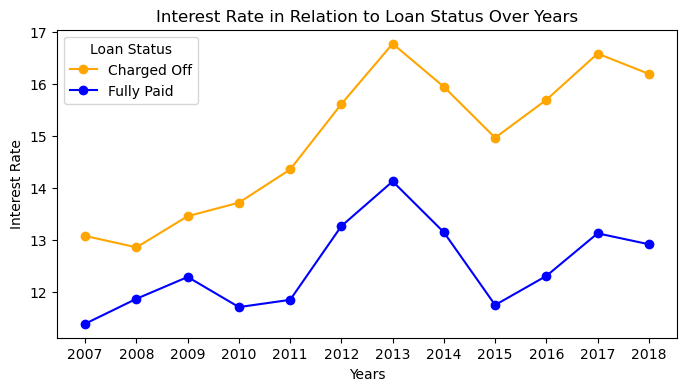

<IPython.core.display.Javascript object>

In [25]:
mean_interest_rate = (
    round(df.groupby(["issue_d", "loan_status"])["int_rate"].mean(), 2)
    .unstack()
    .reset_index()
).set_index("issue_d")
print(mean_interest_rate)
fig, ax = plt.subplots(figsize=(8, 4))
custom_palette = {1: "blue", 0: "orange"}
for col in mean_interest_rate.columns[0:]:
    ax.plot(
        mean_interest_rate.index,
        mean_interest_rate[col],
        marker="o",
        label=col,
        color=custom_palette.get(col),
    )

plt.xticks(mean_interest_rate.index)
ax.set_title("Interest Rate in Relation to Loan Status Over Years")
ax.set_xlabel("Years")
plt.xticks(rotation=0)
ax.set_ylabel("Interest Rate")
legend_labels = ["Charged Off", "Fully Paid"]
plt.legend(title="Loan Status", loc="upper left", labels=legend_labels)

plt.show()

* **Grade** and **Subgrade**

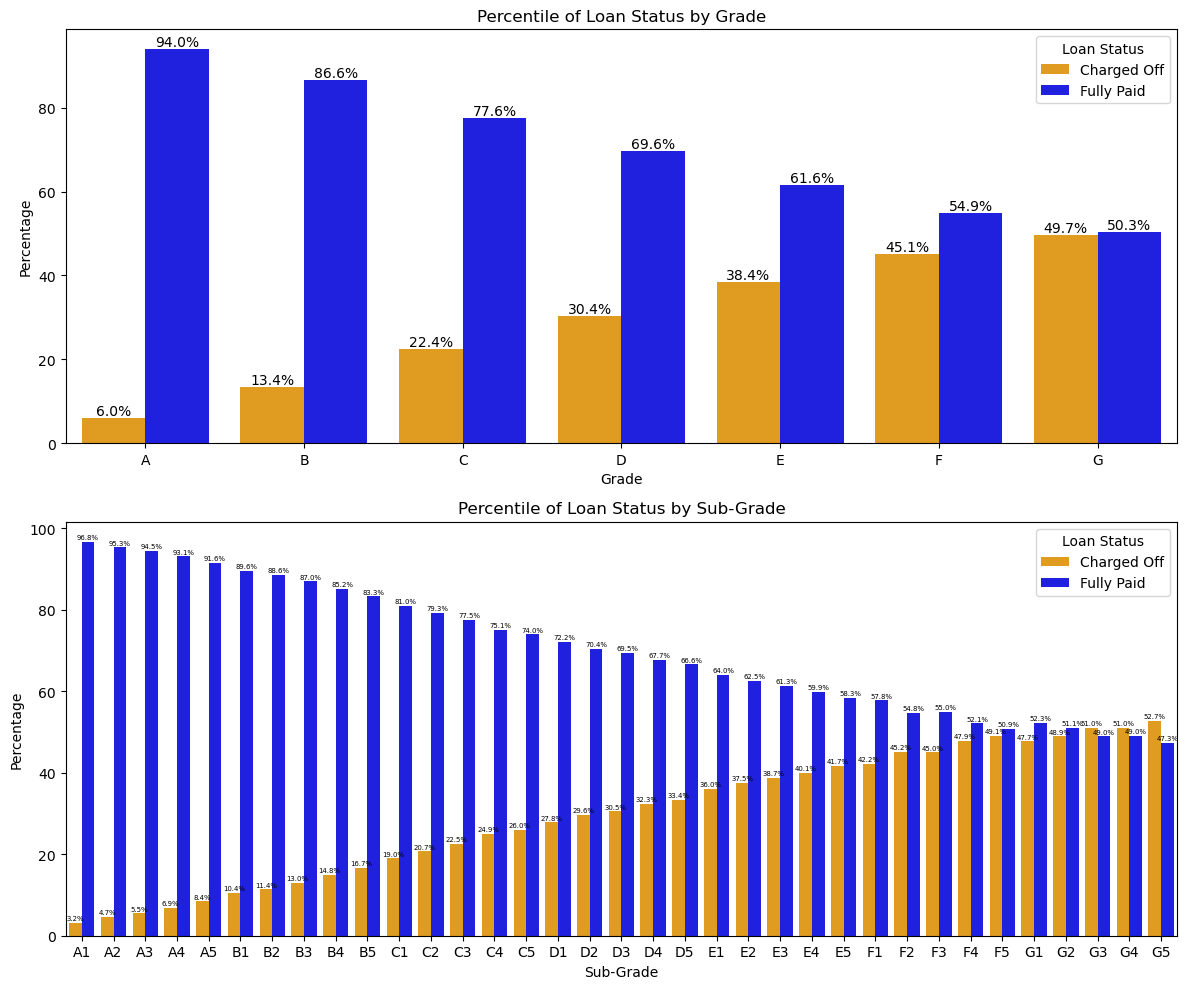

<IPython.core.display.Javascript object>

In [26]:
# Calculate the percentile by grade and loan_status
procentile_grade = (
    df.groupby(["grade", "loan_status"])["loan_status"].count()
    * 100
    / df.groupby(["grade"])["loan_status"].count()
).reset_index(name="Percentile")

# Calculate the percentile by sub_grade and loan_status
procentile_sub_grade = (
    df.groupby(["sub_grade", "loan_status"])["loan_status"].count()
    * 100
    / df.groupby(["sub_grade"])["loan_status"].count()
).reset_index(name="Percentile")

fig, axes = plt.subplots(2, 1, figsize=(12, 10))
custom_palette = {1: "blue", 0: "orange"}
legend_labels = ["Charged Off", "Fully Paid"]

# Plot by grade
sns.barplot(
    data=procentile_grade,
    x="grade",
    y="Percentile",
    hue="loan_status",
    ax=axes[0],
    palette=custom_palette,
)
for i in axes[0].patches:
    axes[0].annotate(
        f"{i.get_height():.1f}%",
        (i.get_x() + i.get_width() / 2, i.get_height()),
        textcoords="offset points",
        xytext=(0, 2),
        size=10,
        ha="center",
    )
axes[0].set_title("Percentile of Loan Status by Grade")
axes[0].set_xlabel("Grade")
axes[0].set_ylabel("Percentage")
handles, labels = axes[0].get_legend_handles_labels()
labels = legend_labels
plt.legend(handles, labels, title="Loan Status", loc="upper right")
# Plot by sub_grade
sns.barplot(
    data=procentile_sub_grade,
    x="sub_grade",
    y="Percentile",
    hue="loan_status",
    ax=axes[1],
    palette=custom_palette,
)
for i in axes[1].patches:
    axes[1].annotate(
        f"{i.get_height():.1f}%",
        (i.get_x() + i.get_width() / 2, i.get_height()),
        textcoords="offset points",
        xytext=(0, 2),
        size=5,
        ha="center",
    )
axes[1].set_title("Percentile of Loan Status by Sub-Grade")
axes[1].set_xlabel("Sub-Grade")
axes[1].set_ylabel("Percentage")
for ax in axes:
    handles, labels = ax.get_legend_handles_labels()
    labels = legend_labels
    ax.legend(handles, labels, title="Loan Status", loc="upper right")


plt.tight_layout()
plt.show()


* **grade** in realtion with **interest_rate**

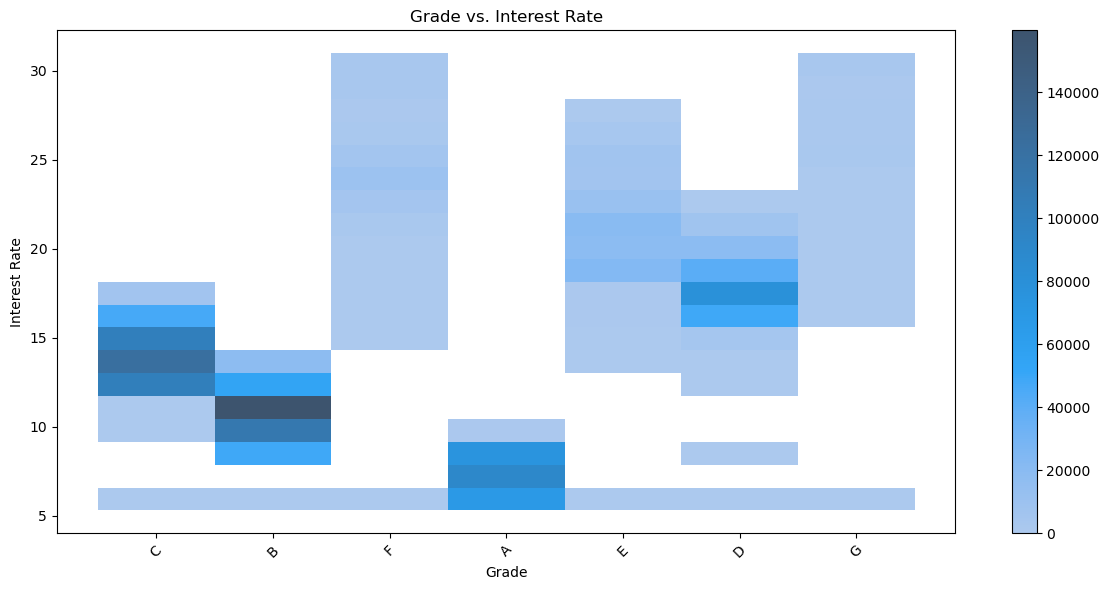

<IPython.core.display.Javascript object>

In [11]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x="grade", y="int_rate", bins=20, cbar=True)

plt.title("Grade vs. Interest Rate")
plt.xlabel("Grade")
plt.ylabel("Interest Rate")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

* **Sub_grade** in realtion with **interest_rate**

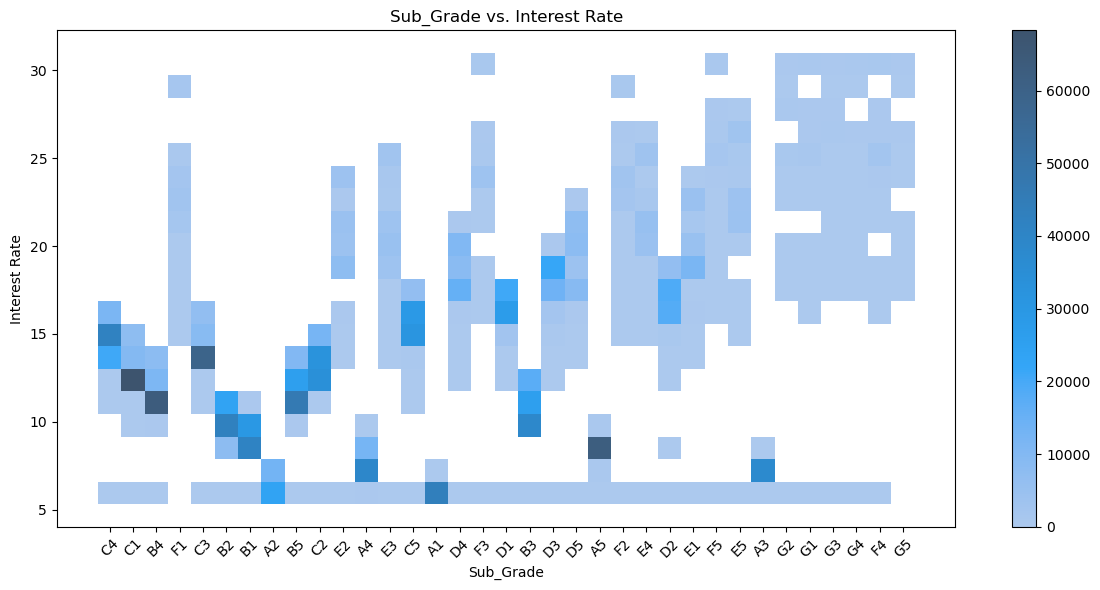

<IPython.core.display.Javascript object>

In [12]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x="sub_grade", y="int_rate", bins=20, cbar=True)

plt.title("Sub_Grade vs. Interest Rate")
plt.xlabel("Sub_Grade")
plt.ylabel("Interest Rate")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

* **Employment length**
Plot shows that loan payoff does not show high relation to employment lengh, but still could be useful for modeling prediction.

In [27]:
# fill missing values with 0:
print("Missing values: ", df["emp_length"].isnull().sum())
df["emp_length"].fillna(value=0, inplace=True)
df["emp_length"].value_counts()

Missing values:  78545


emp_length
10+ years    442669
2 years      122092
< 1 year     108533
3 years      107863
1 year        88842
5 years       84326
4 years       80761
0             78545
6 years       62877
8 years       60808
7 years       59724
9 years       51019
Name: count, dtype: int64

<IPython.core.display.Javascript object>

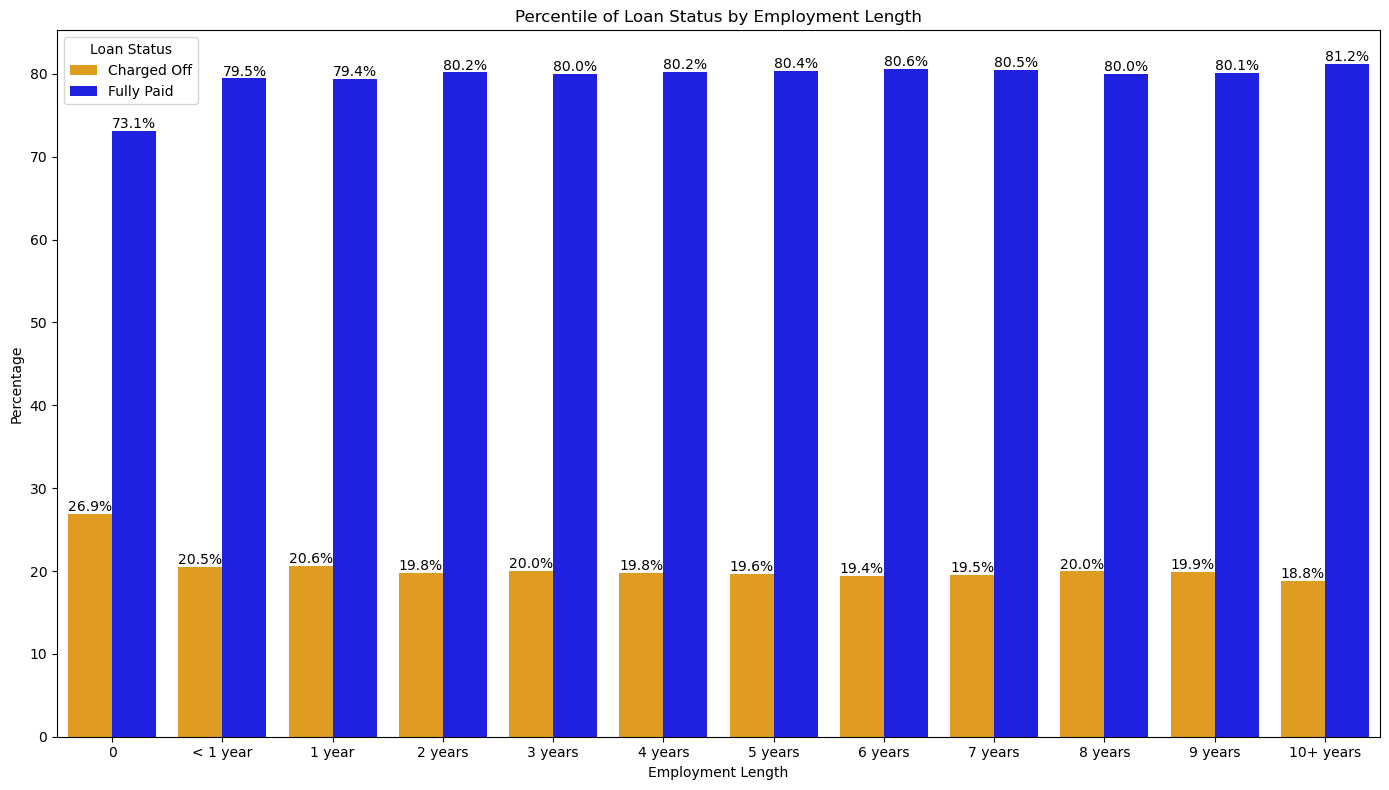

<IPython.core.display.Javascript object>

In [28]:
order = [
    0,
    "< 1 year",
    "1 year",
    "2 years",
    "3 years",
    "4 years",
    "5 years",
    "6 years",
    "7 years",
    "8 years",
    "9 years",
    "10+ years",
]
procentile_employment = (
    df.groupby(["emp_length", "loan_status"])["loan_status"].count()
    * 100
    / df.groupby(["emp_length"])["loan_status"].count()
).reset_index(name="Percentile")

fig = plt.subplots(figsize=(14, 8))
custom_palette = {1: "blue", 0: "orange"}

axes = sns.barplot(
    data=procentile_employment,
    x="emp_length",
    y="Percentile",
    hue="loan_status",
    palette=custom_palette,
    order=order,
)
for i in axes.patches:
    axes.annotate(
        f"{i.get_height():.1f}%",
        (i.get_x() + i.get_width() / 2, i.get_height()),
        textcoords="offset points",
        xytext=(0, 2),
        size=10,
        ha="center",
    )
axes.set_title("Percentile of Loan Status by Employment Length")
axes.set_xlabel("Employment Length")
axes.set_ylabel("Percentage")
legend_labels = ["Charged Off", "Fully Paid"]
handles, labels = axes.get_legend_handles_labels()
labels = legend_labels
axes.legend(handles, labels, title="Loan Status", loc="upper left")

plt.tight_layout()
plt.show()

* **home_ownership**
Home ownership has small influence on loand pay off as well, but I keep it for further modeling prediction

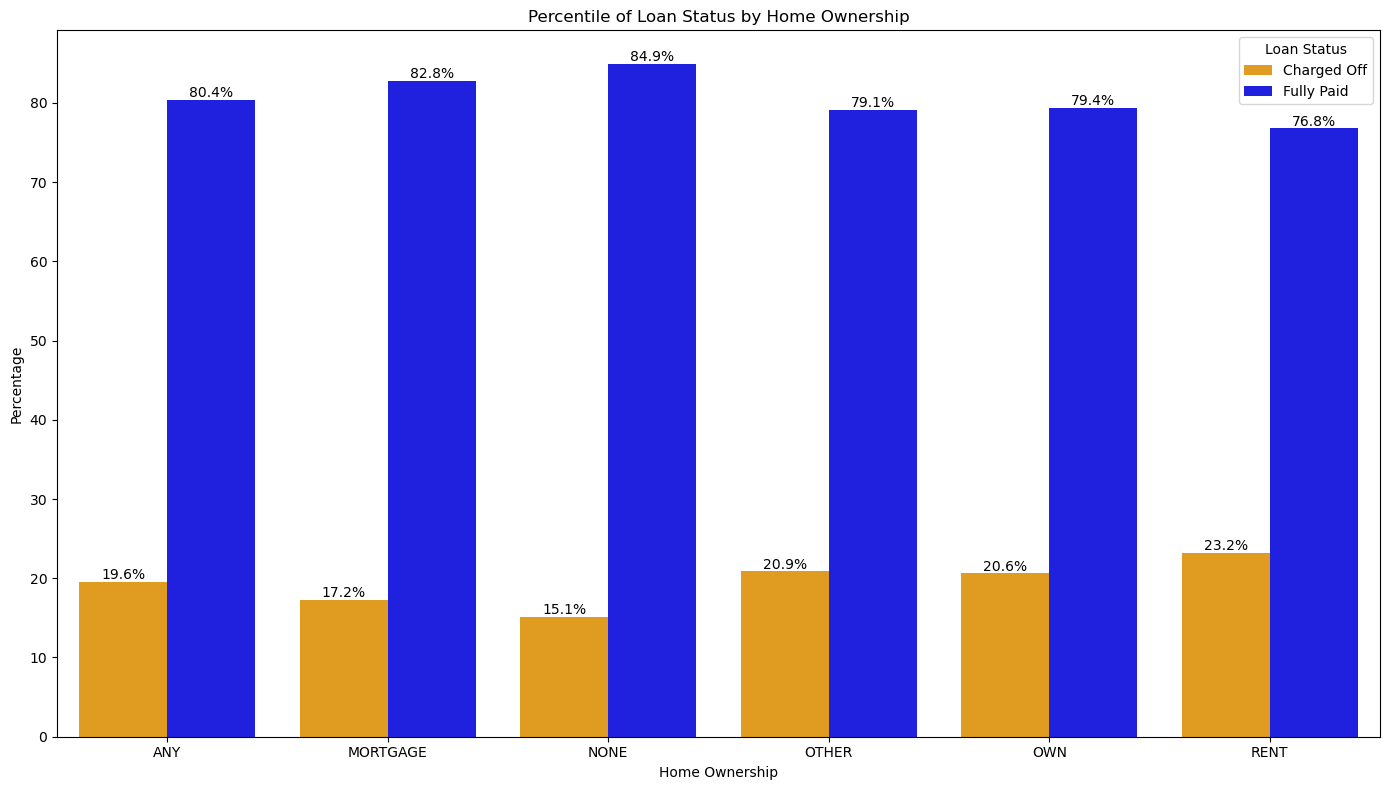

<IPython.core.display.Javascript object>

In [29]:
procentile_home = (
    df.groupby(["home_ownership", "loan_status"])["loan_status"].count()
    * 100
    / df.groupby(["home_ownership"])["loan_status"].count()
).reset_index(name="Percentile")

fig = plt.subplots(figsize=(14, 8))
custom_palette = {1: "blue", 0: "orange"}

axes = sns.barplot(
    data=procentile_home,
    x="home_ownership",
    y="Percentile",
    hue="loan_status",
    palette=custom_palette,
)
for i in axes.patches:
    axes.annotate(
        f"{i.get_height():.1f}%",
        (i.get_x() + i.get_width() / 2, i.get_height()),
        textcoords="offset points",
        xytext=(0, 2),
        size=10,
        ha="center",
    )
axes.set_title("Percentile of Loan Status by Home Ownership")
axes.set_xlabel("Home Ownership")
axes.set_ylabel("Percentage")
legend_labels = ["Charged Off", "Fully Paid"]
handles, labels = axes.get_legend_handles_labels()
labels = legend_labels
axes.legend(handles, labels, title="Loan Status", loc="upper right")
plt.tight_layout()
plt.show()

* **annual_inc**

In 2007 and 2008 we see an interesting trend, with higher income clients being classified as charged off loans. Based on the previous interest rates, we would conclude that higher interest rates were given to higher earning clients.

loan_status         0         1
issue_d                        
2007         69679.78  62973.25
2008         69211.69  64203.74
2009         64115.79  69997.53
2010         63080.23  70561.45
2011         62173.57  70759.21
2012         63682.07  70887.28
2013         67044.09  74369.37
2014         68306.76  75965.33
2015         70433.33  77745.07
2016         72420.53  80706.67
2017         72870.05  80781.58
2018         72930.73  81410.15


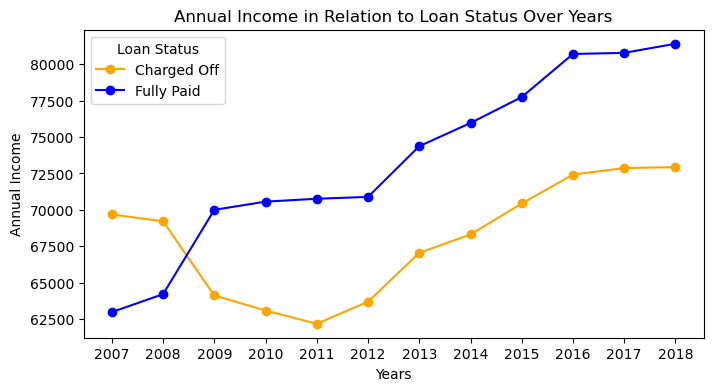

<IPython.core.display.Javascript object>

In [30]:
mean_income = (
    round(df.groupby(["issue_d", "loan_status"])["annual_inc"].mean(), 2)
    .unstack()
    .reset_index()
).set_index("issue_d")
print(mean_income)
fig, ax = plt.subplots(figsize=(8, 4))
custom_palette = {1: "blue", 0: "orange"}
for col in mean_income.columns[0:]:
    ax.plot(
        mean_income.index,
        mean_income[col],
        marker="o",
        label=col,
        color=custom_palette.get(col),
    )

plt.xticks(mean_income.index)
ax.set_title("Annual Income in Relation to Loan Status Over Years")
ax.set_xlabel("Years")
plt.xticks(rotation=0)
ax.set_ylabel("Annual Income")
legend_labels = ["Charged Off", "Fully Paid"]
plt.legend(title="Loan Status", loc="upper left", labels=legend_labels)
plt.show()

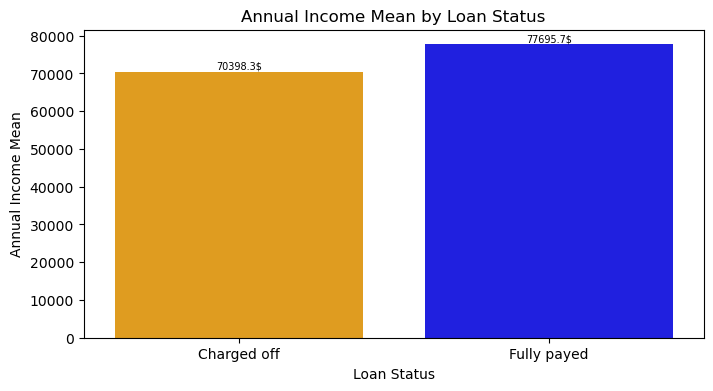

<IPython.core.display.Javascript object>

In [31]:
mean_income2 = round(df.groupby("loan_status")["annual_inc"].mean(), 2).reset_index()

plt.figure(figsize=(8, 4))
custom_palette = {1: "blue", 0: "orange"}
ax = sns.barplot(
    x="loan_status", y="annual_inc", data=mean_income2, palette=custom_palette
)
plt.title("Annual Income Mean by Loan Status")
plt.xlabel("Loan Status")
plt.ylabel("Annual Income Mean")
for i in ax.patches:
    ax.annotate(
        f"{i.get_height():.1f}$",
        (i.get_x() + i.get_width() / 2, i.get_height()),
        textcoords="offset points",
        xytext=(0, 2),
        size=7,
        ha="center",
    )
plt.xticks([0, 1], ["Charged off", "Fully payed"])
plt.show()

* **purpose**
I find it interesting, that around 30% charged off loans were for small_business.

In [32]:
df["purpose"].value_counts()

purpose
debt_consolidation    781421
credit_card           295619
home_improvement       87718
other                  78299
major_purchase         29548
medical                15612
small_business         15577
car                    14649
moving                  9526
vacation                9084
house                   7297
wedding                 2350
renewable_energy         936
educational              423
Name: count, dtype: int64

<IPython.core.display.Javascript object>

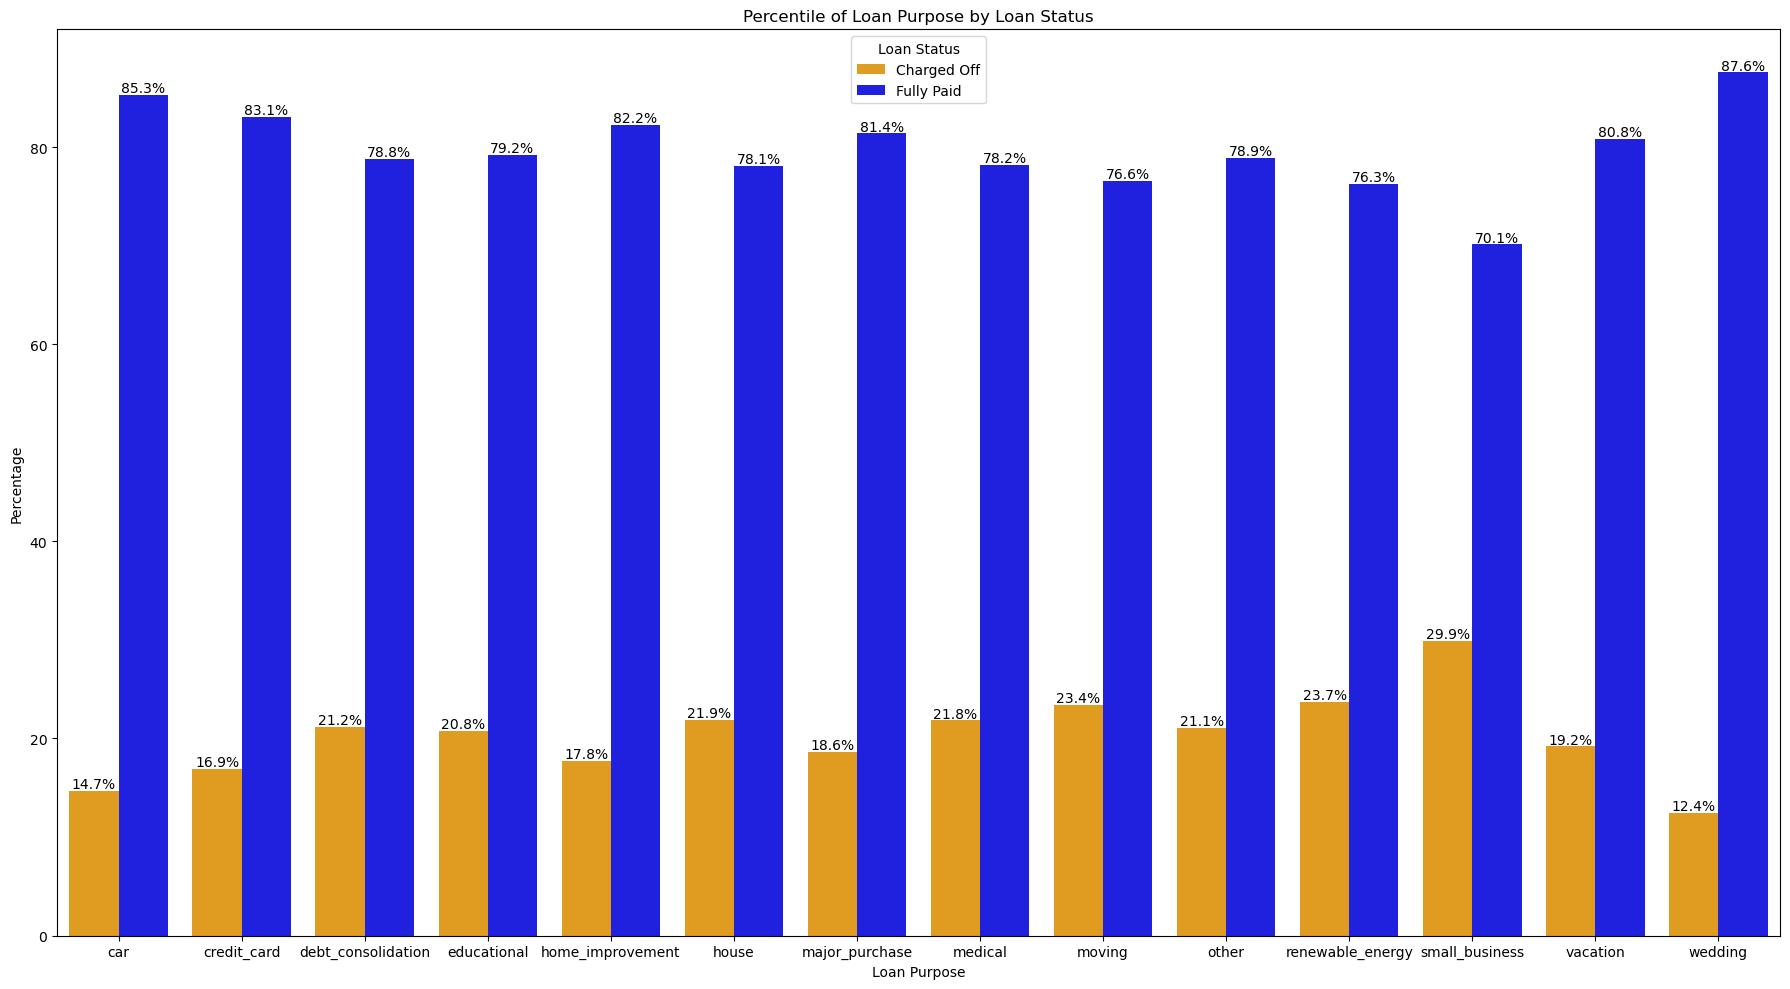

<IPython.core.display.Javascript object>

In [33]:
procentile_purpose = (
    df.groupby(["purpose", "loan_status"])["loan_status"].count()
    * 100
    / df.groupby(["purpose"])["loan_status"].count()
).reset_index(name="Percentile")

fig = plt.subplots(figsize=(18, 10))
custom_palette = {1: "blue", 0: "orange"}

axes = sns.barplot(
    data=procentile_purpose,
    x="purpose",
    y="Percentile",
    hue="loan_status",
    palette=custom_palette,
)
for i in axes.patches:
    axes.annotate(
        f"{i.get_height():.1f}%",
        (i.get_x() + i.get_width() / 2, i.get_height()),
        textcoords="offset points",
        xytext=(0, 2),
        size=10,
        ha="center",
    )
axes.set_title("Percentile of Loan Purpose by Loan Status")
axes.set_xlabel("Loan Purpose")
axes.set_ylabel("Percentage")
handles, labels = axes.get_legend_handles_labels()
labels = legend_labels
axes.legend(handles, labels, title="Loan Status", loc="upper center")
plt.tight_layout()
plt.show()

* **addr_state**
from all states only two states stay out this highest percetage of charged off loans: Mississippi (26%) and Nebraska (25%).

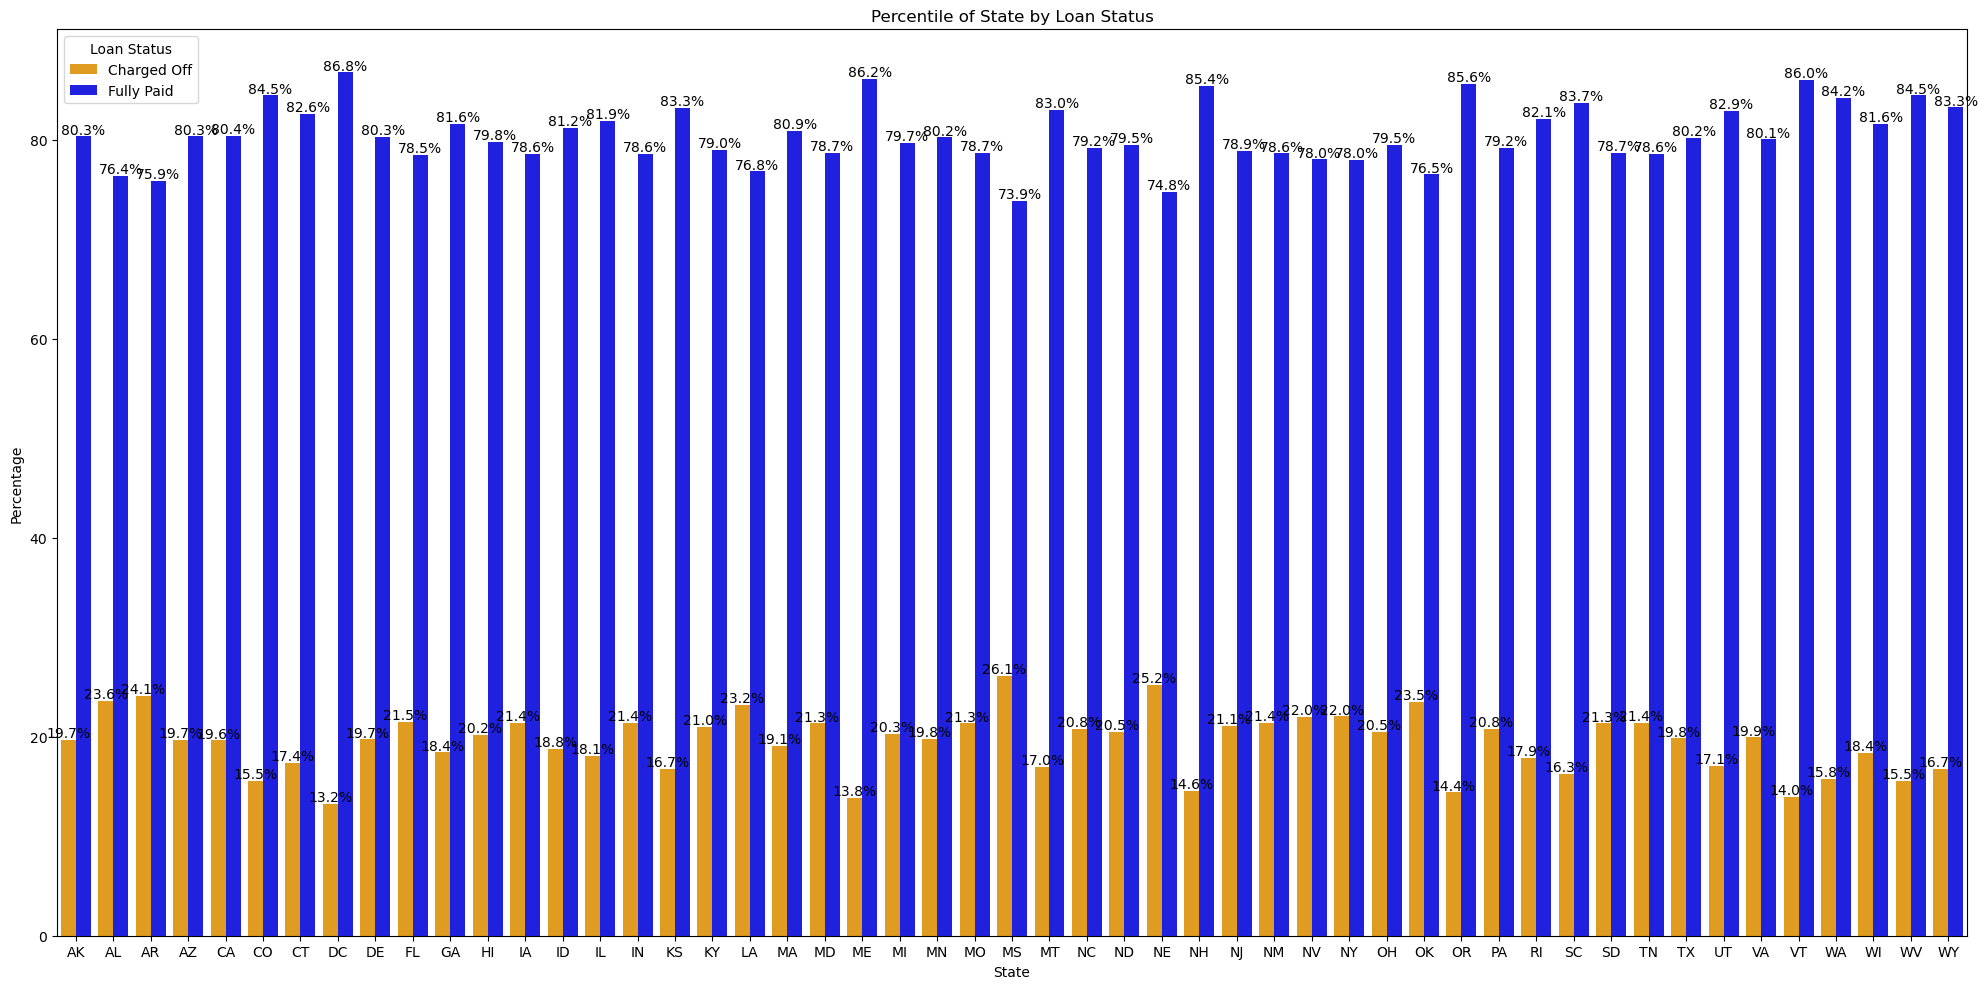

<IPython.core.display.Javascript object>

In [34]:
procentile_state = (
    df.groupby(["addr_state", "loan_status"])["loan_status"].count()
    * 100
    / df.groupby(["addr_state"])["loan_status"].count()
).reset_index(name="Percentile")

fig = plt.subplots(figsize=(20, 10))
custom_palette = {1: "blue", 0: "orange"}

axes = sns.barplot(
    data=procentile_state,
    x="addr_state",
    y="Percentile",
    hue="loan_status",
    palette=custom_palette,
)
for i in axes.patches:
    axes.annotate(
        f"{i.get_height():.1f}%",
        (i.get_x() + i.get_width() / 2, i.get_height()),
        textcoords="offset points",
        xytext=(0, 2),
        size=10,
        ha="center",
    )
axes.set_title("Percentile of State by Loan Status")
axes.set_xlabel("State")
axes.set_ylabel("Percentage")
handles, labels = axes.get_legend_handles_labels()
labels = legend_labels
axes.legend(handles, labels, title="Loan Status", loc="upper left")
plt.tight_layout()
plt.show()

* **earliest_cr_line**
The aim is to count how many years have passed since the borrower opened his first credit line. A higher number of years indicates that the borrower may be more solvent.

In [35]:
df["earliest_cr_line"] = pd.to_datetime(
    df["earliest_cr_line"], format="%b-%Y", errors="coerce"
)
date_today = dt.datetime.now()
df["credit_history"] = (date_today - df["earliest_cr_line"]).dt.days // 365
df["credit_history"].fillna(0, inplace=True)
df["credit_history"] = df["credit_history"].astype(int)
df.drop("earliest_cr_line", axis=1, inplace=True)

<IPython.core.display.Javascript object>

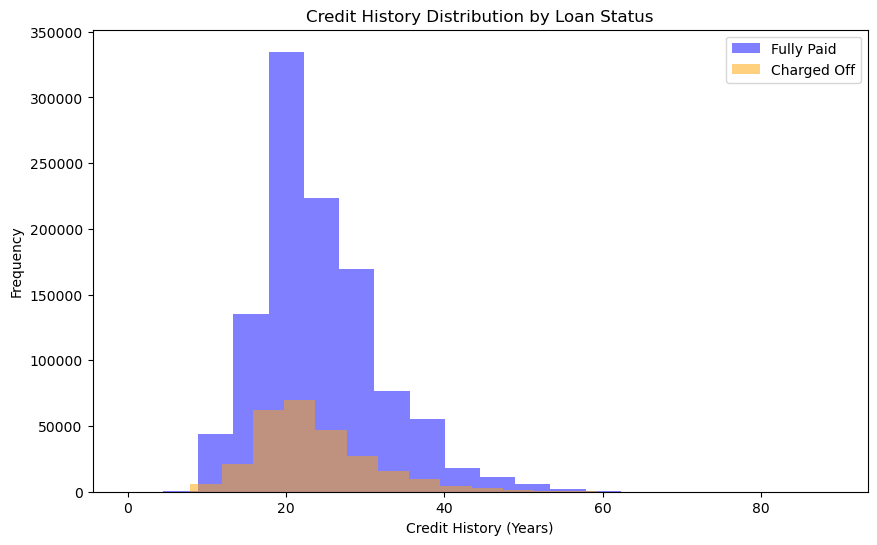

<IPython.core.display.Javascript object>

In [36]:
plt.figure(figsize=(10, 6))

# Filter the DataFrame based on loan_status
fully_paid = df[df["loan_status"] == 1]
charged_off = df[df["loan_status"] == 0]

# Plot histograms for fully paid and charged off loans
plt.hist(
    fully_paid["credit_history"],
    bins=20,
    alpha=0.5,
    color="blue",
    label="Fully Paid",
)
plt.hist(
    charged_off["credit_history"],
    bins=20,
    alpha=0.5,
    color="orange",
    label="Charged Off",
)

plt.xlabel("Credit History (Years)")
plt.ylabel("Frequency")
plt.title("Credit History Distribution by Loan Status")
plt.legend()
plt.show()

* **fico_range_low** and **fico_range_high**
I will create the mean score for FICO score.
* good score : 670 - 800+
* fair score : 580-669
* bad score : <580

In [37]:
df["fico_mean"] = df[["fico_range_low", "fico_range_high"]].mean(axis=1)
df.drop(["fico_range_low", "fico_range_high"], axis=1, inplace=True)

<IPython.core.display.Javascript object>

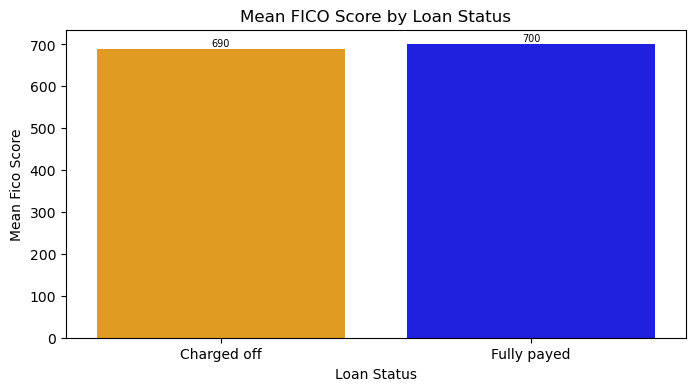

<IPython.core.display.Javascript object>

In [38]:
fico_mean = round(df.groupby("loan_status")["fico_mean"].mean(), 2).reset_index()

plt.figure(figsize=(8, 4))
custom_palette = {1: "blue", 0: "orange"}
ax = sns.barplot(x="loan_status", y="fico_mean", data=fico_mean, palette=custom_palette)
plt.title("Mean FICO Score by Loan Status")
plt.xlabel("Loan Status")
plt.ylabel("Mean Fico Score")
for i in ax.patches:
    ax.annotate(
        f"{i.get_height():.0f}",
        (i.get_x() + i.get_width() / 2, i.get_height()),
        textcoords="offset points",
        xytext=(0, 2),
        size=7,
        ha="center",
    )
plt.xticks([0, 1], ["Charged off", "Fully payed"])
plt.show()

For missing values I will provide imputation numeric values - median, categorical - most frequent.

### Statistical analysis:

* Dealing with outliers: I have changed them into values of lowerbound and upperbound;
* Normality check helps to predict the data distribution;
* Checking the statistical significance , mean difference and providing confidence intervals for few numeric features:

In [23]:
num_features = df.select_dtypes(exclude=["object"]).columns.tolist()

<IPython.core.display.Javascript object>

In [24]:
def replace_outliers_with_iqr(data, multiplier=1.5):
    data = np.array(data)
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1

    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    cleaned_data = np.where(data < lower_bound, lower_bound, data)
    cleaned_data = np.where(cleaned_data > upper_bound, upper_bound, cleaned_data)

    return cleaned_data


df[num_features] = df[num_features].apply(replace_outliers_with_iqr)

<IPython.core.display.Javascript object>

In [43]:
def data_normality_check(data, column):
    statistic, p_value = shapiro(data[column])
    print(f"Test Statistic: {statistic}")
    print(f"P-value: {p_value}")
    alpha = 0.05
    if p_value > alpha:
        print(
            "The data follows a normal distribution (fail to reject the null hypothesis)."
        )
    else:
        print(
            "The data does not follow a normal distribution (reject the null hypothesis)."
        )

<IPython.core.display.Javascript object>

In [44]:
def plot_hist(dataframe, column_name, message):
    fig, ax = plt.subplots(1, figsize=(10, 3))
    sns.histplot(dataframe[column_name], kde=True)
    ax.set_title("Histogram - {} for {} Clients".format(column_name, message))
    ax.set_xlabel(column_name)
    plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>

In [45]:
def statistical_significance(data1, data2, alpha=0.05, alternative="two-sided"):
    statistic, p_value = mannwhitneyu(data1, data2, alternative=alternative)
    print("P-value:", p_value)
    if p_value < alpha:
        print("There is a statistically significant difference between the groups.")
    else:
        print("There is no statistically significant difference between the groups.")


<IPython.core.display.Javascript object>

In [46]:
def mean_difference(data1, data2):
    column_name = data1.name
    mean_difference = round(data1.mean() - data2.mean(), 2)
    print(f"The difference between groups in {column_name} mean: {mean_difference}")

<IPython.core.display.Javascript object>

In [47]:
def confidence_interval(dataframe, column_name, confidence_level=0.95):
    data = dataframe[column_name]

    mean = data.mean()
    std = data.std()
    n = len(data)

    standard_error = std / np.sqrt(n)
    margin_of_error = standard_error * 1.96

    lower_bound = round((mean - margin_of_error), 2)
    upper_bound = round((mean + margin_of_error), 2)

    print(
        "{}% Confidence Interval for {} mean: [{:.2f}, {:.2f}]".format(
            confidence_level * 100, column_name, lower_bound, upper_bound
        )
    )

<IPython.core.display.Javascript object>

** Hypothesis** : loan amount is not statistically significant between charged off and fully payed groups;<br>
** Alternative** there is significant difference

Test Statistic: 0.9386507272720337
P-value: 0.0
The data does not follow a normal distribution (reject the null hypothesis).


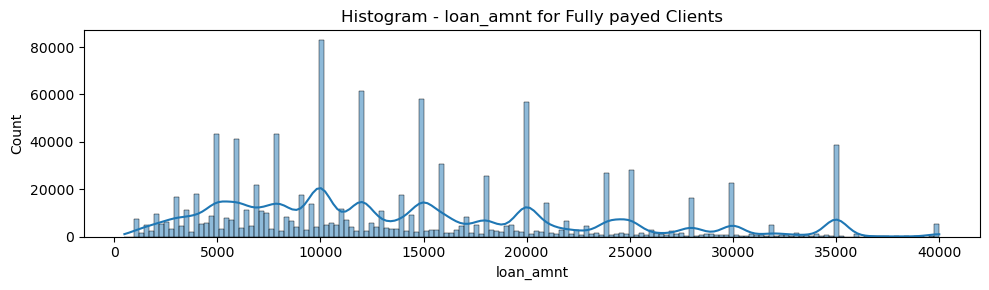

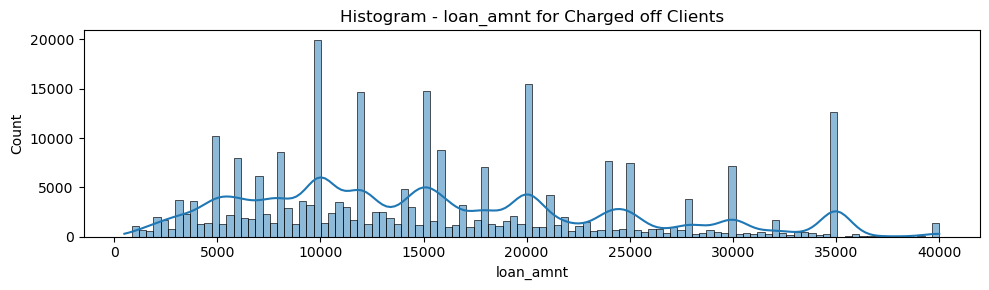

P-value: 0.0
There is a statistically significant difference between the groups.
The difference between groups in loan_amnt mean: -1423.36
Fully payed loans:
95.0% Confidence Interval for loan_amnt mean: [14108.28, 14140.99]
Charged off loans:
95.0% Confidence Interval for loan_amnt mean: [15514.70, 15581.29]


<IPython.core.display.Javascript object>

In [48]:
data_normality_check(df, "loan_amnt")
plot_hist(fully_payed_df, "loan_amnt", "Fully payed")
plot_hist(charged_off_df, "loan_amnt", "Charged off")
statistical_significance(fully_payed_df["loan_amnt"], charged_off_df["loan_amnt"])
mean_difference(fully_payed_df["loan_amnt"], charged_off_df["loan_amnt"])
print("Fully payed loans:")
confidence_interval(fully_payed_df, "loan_amnt")
print("Charged off loans:")
confidence_interval(charged_off_df, "loan_amnt")

** Hypothesis** : annual income is not statistically significant between charged off and fully payed groups;
** Alternative** there is significant difference:

Test Statistic: 0.9343488812446594
P-value: 0.0
The data does not follow a normal distribution (reject the null hypothesis).


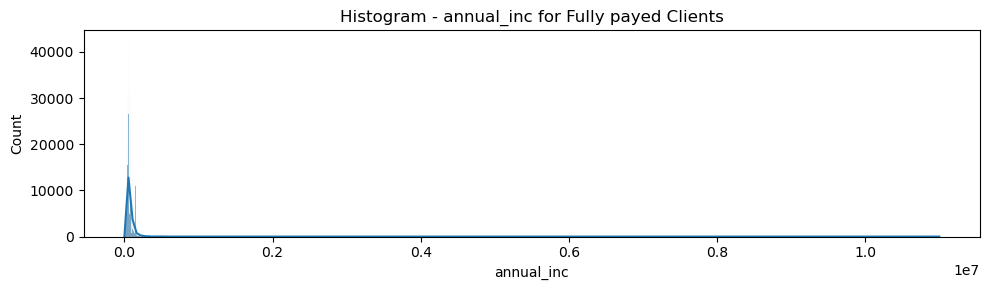

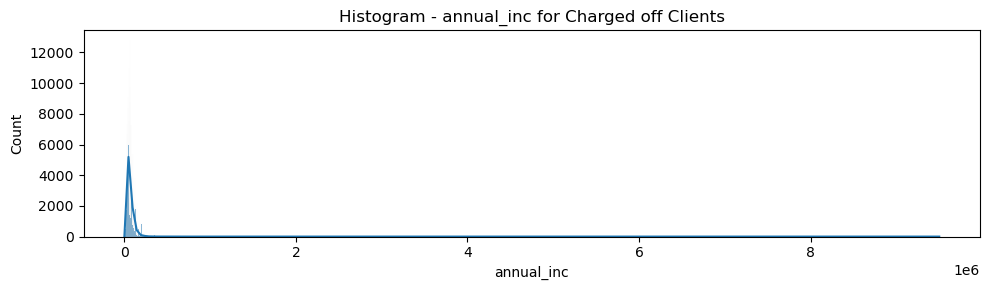

P-value: 0.0048705813750920405
There is a statistically significant difference between the groups.
The difference between groups in annual_inc mean: 7297.45
Fully payed loans:
95.0% Confidence Interval for annual_inc mean: [77561.86, 77829.58]
Charged off loans:
95.0% Confidence Interval for annual_inc mean: [70151.32, 70645.22]


<IPython.core.display.Javascript object>

In [49]:
data_normality_check(df, "annual_inc")
plot_hist(fully_payed_df, "annual_inc", "Fully payed")
plot_hist(charged_off_df, "annual_inc", "Charged off")

sample_size = 1000
sample_fully_paid = fully_payed_df["annual_inc"].sample(sample_size, random_state=42)
sample_charged_off = charged_off_df["annual_inc"].sample(sample_size, random_state=42)
statistic, p_value = stats.mannwhitneyu(
    sample_fully_paid, sample_charged_off, alternative="two-sided"
)
print("P-value:", p_value)
if p_value < 0.05:
    print("There is a statistically significant difference between the groups.")
else:
    print("There is no statistically significant difference between the groups.")

mean_difference(fully_payed_df["annual_inc"], charged_off_df["annual_inc"])
print("Fully payed loans:")
confidence_interval(fully_payed_df, "annual_inc")
print("Charged off loans:")
confidence_interval(charged_off_df, "annual_inc")

** Hypothesis** : Credit history is not statistically significant between charged off and fully payed groups;<br>
** Alternative** there is significant difference

Test Statistic: 0.968207836151123
P-value: 0.0
The data does not follow a normal distribution (reject the null hypothesis).
P-value: 0.0
There is a statistically significant difference between the groups.
The difference between groups in credit_history mean: 0.83
Fully payed loans:
95.0% Confidence Interval for credit_history mean: [24.20, 24.23]
Charged off loans:
95.0% Confidence Interval for credit_history mean: [23.35, 23.41]


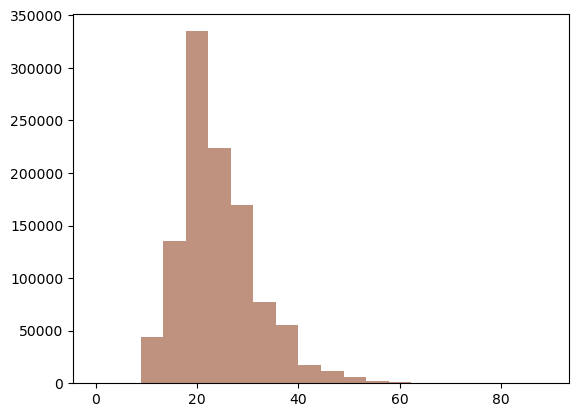

<IPython.core.display.Javascript object>

In [50]:
data_normality_check(df, "credit_history")
plt.hist(
    fully_payed_df["credit_history"],
    bins=20,
    alpha=0.5,
    color="blue",
    label="Fully Paid",
)
plt.hist(
    fully_payed_df["credit_history"],
    bins=20,
    alpha=0.5,
    color="orange",
    label="Charged Off",
)

statistical_significance(
    fully_payed_df["credit_history"], charged_off_df["credit_history"]
)
mean_difference(fully_payed_df["credit_history"], charged_off_df["credit_history"])
print("Fully payed loans:")
confidence_interval(fully_payed_df, "credit_history")
print("Charged off loans:")
confidence_interval(charged_off_df, "credit_history")

** Hypothesis** : Averrage FICO score is not statistically significant between charged off and fully payed groups;<br>
** Alternative** there is significant difference

Test Statistic: 0.905361533164978
P-value: 0.0
The data does not follow a normal distribution (reject the null hypothesis).


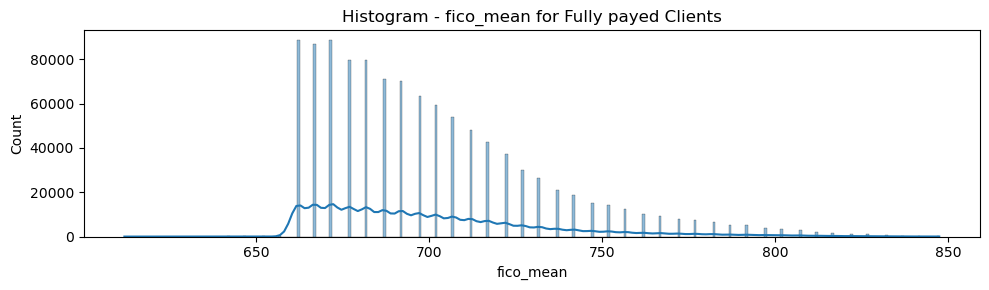

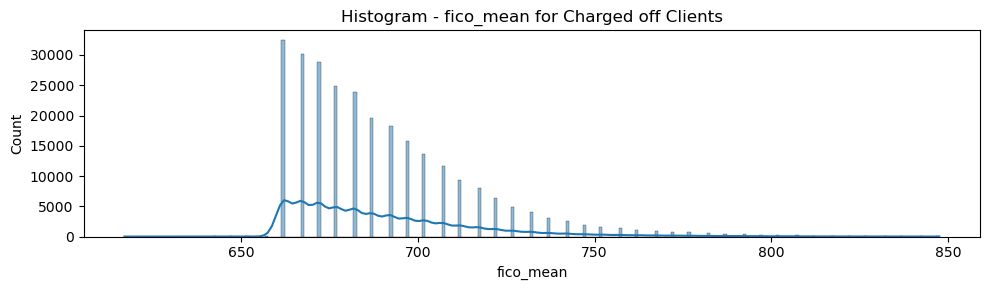

P-value: 0.0
There is a statistically significant difference between the groups.
The difference between groups in fico_mean mean: 10.41
Fully payed loans:
95.0% Confidence Interval for fico_mean mean: [700.18, 700.30]
Charged off loans:
95.0% Confidence Interval for fico_mean mean: [689.73, 689.93]


<IPython.core.display.Javascript object>

In [51]:
data_normality_check(df, "fico_mean")
plot_hist(fully_payed_df, "fico_mean", "Fully payed")
plot_hist(charged_off_df, "fico_mean", "Charged off")
statistical_significance(fully_payed_df["fico_mean"], charged_off_df["fico_mean"])
mean_difference(fully_payed_df["fico_mean"], charged_off_df["fico_mean"])
print("Fully payed loans:")
confidence_interval(fully_payed_df, "fico_mean")
print("Charged off loans:")
confidence_interval(charged_off_df, "fico_mean")

### Conclusions:
As we are working with a very large database, the work has been a huge drain on time and resources.
The general trends we are seeing amongst both solvent and especially insolvent loans:
* since 2015, there has been a clear gradient in the amount of loans granted, which has been decreasing significantly in the older years;
* While the total amount of loans has been decreasing, the average amount lent has remained almost unchanged and even increased in 2018;
* The interest rate in 2007-2008 was higher for higher-income customers and the trend shows that it was initially highest among non-insolvent customers.
* Interest rates show very clearly the link between the declining rate and the higher demand for borrowing, and this is the link between the increased insolvency of customers.
* Most of the insolvent customers are borrowing for small businesses.
* insolvent customers are concentrated in the state of Mississippi.

My modeling part is on the file loan_modeling.ipynb, together with attempted app deployment in app.py

### Improvement:
Always requires additional knowledge of theory as well as practice in coding.
Further use of more complex models and sharing good practice with DS specialists. Practice in App development and deployment is necessary.